In [1]:
import torch
torch.set_default_dtype(torch.float32)

import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

import utils as UT
import optimizers as OPT
import config as CFG

import importlib
importlib.reload(CFG)
importlib.reload(OPT)
importlib.reload(UT)

<module 'utils' from '/home/solomon/BSGD/utils.py'>

## XOR Data

In [2]:
device = "cpu"

In [221]:
from torch.utils.data import DataLoader, TensorDataset, random_split

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [0]])

N = 1000
BATCH_SIZE = 64

X = np.vstack([X for _ in range(N//4)])
Y = np.vstack([Y for _ in range(N//4)])

X = torch.Tensor(X, device=device)
Y = torch.Tensor(Y, device=device)

sig = 0.15

X += torch.normal(0, sig, size=X.shape)

# Dataloader for PyTorch
dataset = TensorDataset(X, Y)
train_dataset, valid_dataset = random_split(dataset, [900, 100], generator=torch.Generator().manual_seed(69))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=True)

In [222]:
plt.style.use('bmh')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Sans'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 25

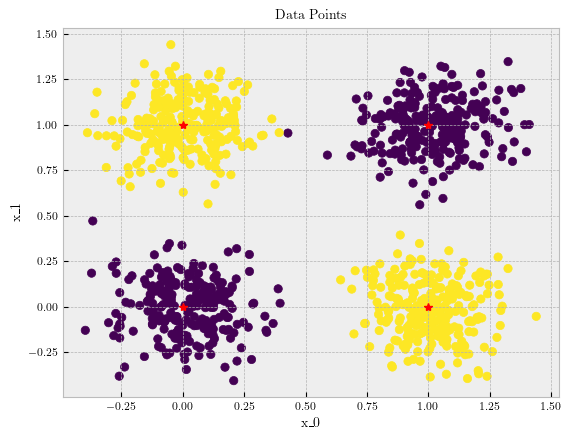

In [223]:
plt.figure()
plt.title("Data Points")
plt.scatter(X[:, 0], X[:, 1], c=Y+2)
plt.xlabel('x_0')
plt.ylabel('x_1')
plt.plot(0, 0, "*r")
plt.plot(0, 1, "*r")
plt.plot(1, 0, "*r")
plt.plot(1, 1, "*r")

# Creating torch model

In [224]:
import torch.nn as nn
import torch.optim as optim 

class XOR_classifier(nn.Module):
    
    def __init__(self):
        super(XOR_classifier, self).__init__()
        
        self.fc1 = nn.Linear(2, 100)
        self.act1 = nn.Tanh() 
        self.fc2 = nn.Linear(100, 2)
        self.act2 = nn.Softmax(dim=1)
    
    def forward(self, x):
        z = self.fc1(x)
        z = self.act1(z)
        
        z = self.fc2(z)
        z = self.act2(z)
        return z

In [240]:
model = XOR_classifier()

In [241]:
crieterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.1)
optimizer = optim.NAdam(model.parameters())

In [242]:
from tqdm import tqdm

In [243]:
nEpochs = 100

train_heur = {'loss': [], 'accuracy':[]}
valid_heur = {'loss': [], 'accuracy':[]}

steps = 0

while steps < nEpochs:
    model.train()
    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        y_pred = y_pred[:, 1].unsqueeze(1)
        loss = crieterion(y_pred, y)
        acc = (y_pred >= 0.5) == y
        acc = torch.sum(acc)/y.shape[1]

        train_heur['loss'].append(loss.item())
        train_heur['accuracy'].append(acc.detach().cpu())
        
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        model.eval()
        for x, y in valid_dataloader:
            y_pred = model(x)
            y_pred = y_pred[:, 1].unsqueeze(1)
            
            loss = crieterion(y_pred, y)
            acc = (y_pred >= 0.5) == y
            acc = torch.sum(acc)/y.shape[1]

            valid_heur['loss'].append(loss.item())
            valid_heur['accuracy'].append(acc.detach().cpu())
    print("EPOCH {}: Train Acc: {} Valid Acc: {}".format(steps, np.mean(train_heur['accuracy']), valid_heur['accuracy'][-1]))
    steps += 1

100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 617.34it/s]


EPOCH 0: Train Acc: 29.600000381469727 Valid Acc: 47.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 458.03it/s]


EPOCH 1: Train Acc: 29.399999618530273 Valid Acc: 55.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 649.23it/s]


EPOCH 2: Train Acc: 30.0222225189209 Valid Acc: 57.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 466.86it/s]


EPOCH 3: Train Acc: 32.41666793823242 Valid Acc: 59.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 557.49it/s]


EPOCH 4: Train Acc: 35.54666519165039 Valid Acc: 54.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 555.27it/s]


EPOCH 5: Train Acc: 37.27777862548828 Valid Acc: 73.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 568.59it/s]


EPOCH 6: Train Acc: 39.67618942260742 Valid Acc: 57.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 640.08it/s]


EPOCH 7: Train Acc: 41.32500076293945 Valid Acc: 98.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 597.68it/s]


EPOCH 8: Train Acc: 43.25925827026367 Valid Acc: 90.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 551.79it/s]


EPOCH 9: Train Acc: 44.90666580200195 Valid Acc: 90.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 546.62it/s]


EPOCH 10: Train Acc: 46.16363525390625 Valid Acc: 95.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 463.80it/s]


EPOCH 11: Train Acc: 47.27777862548828 Valid Acc: 100.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 635.94it/s]


EPOCH 12: Train Acc: 48.25640869140625 Valid Acc: 100.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 566.41it/s]


EPOCH 13: Train Acc: 49.090476989746094 Valid Acc: 97.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 578.24it/s]


EPOCH 14: Train Acc: 49.813331604003906 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 480.03it/s]


EPOCH 15: Train Acc: 50.44583511352539 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 514.74it/s]


EPOCH 16: Train Acc: 51.007843017578125 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 648.14it/s]


EPOCH 17: Train Acc: 51.507408142089844 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 550.92it/s]


EPOCH 18: Train Acc: 51.95438766479492 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 615.46it/s]


EPOCH 19: Train Acc: 52.356666564941406 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 669.10it/s]


EPOCH 20: Train Acc: 52.72063446044922 Valid Acc: 100.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 505.31it/s]


EPOCH 21: Train Acc: 53.051513671875 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 515.39it/s]


EPOCH 22: Train Acc: 53.35362243652344 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 613.33it/s]


EPOCH 23: Train Acc: 53.63055419921875 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 423.02it/s]


EPOCH 24: Train Acc: 53.88533401489258 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 582.06it/s]


EPOCH 25: Train Acc: 54.120513916015625 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 709.98it/s]


EPOCH 26: Train Acc: 54.33827209472656 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 581.98it/s]


EPOCH 27: Train Acc: 54.54047775268555 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 505.41it/s]


EPOCH 28: Train Acc: 54.728736877441406 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 720.78it/s]


EPOCH 29: Train Acc: 54.90444564819336 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 588.15it/s]


EPOCH 30: Train Acc: 55.068817138671875 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 359.30it/s]


EPOCH 31: Train Acc: 55.22291564941406 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 433.49it/s]


EPOCH 32: Train Acc: 55.36767578125 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 534.10it/s]


EPOCH 33: Train Acc: 55.50392150878906 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 714.57it/s]


EPOCH 34: Train Acc: 55.632381439208984 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 667.30it/s]


EPOCH 35: Train Acc: 55.75370407104492 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 601.39it/s]


EPOCH 36: Train Acc: 55.86846923828125 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 582.81it/s]


EPOCH 37: Train Acc: 55.97719192504883 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 582.90it/s]


EPOCH 38: Train Acc: 56.08034133911133 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 655.26it/s]


EPOCH 39: Train Acc: 56.1783332824707 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 619.21it/s]


EPOCH 40: Train Acc: 56.27154541015625 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 622.23it/s]


EPOCH 41: Train Acc: 56.36031723022461 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 615.15it/s]


EPOCH 42: Train Acc: 56.44496154785156 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 626.44it/s]


EPOCH 43: Train Acc: 56.5257568359375 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 593.81it/s]


EPOCH 44: Train Acc: 56.602962493896484 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 591.43it/s]


EPOCH 45: Train Acc: 56.67681121826172 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 598.45it/s]


EPOCH 46: Train Acc: 56.74751663208008 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 554.47it/s]


EPOCH 47: Train Acc: 56.815277099609375 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 543.67it/s]


EPOCH 48: Train Acc: 56.880271911621094 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 524.32it/s]


EPOCH 49: Train Acc: 56.942665100097656 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 519.34it/s]


EPOCH 50: Train Acc: 57.00261306762695 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 506.66it/s]


EPOCH 51: Train Acc: 57.06025695800781 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 594.68it/s]


EPOCH 52: Train Acc: 57.11572265625 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 507.89it/s]


EPOCH 53: Train Acc: 57.16913604736328 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 580.81it/s]


EPOCH 54: Train Acc: 57.22060775756836 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 626.84it/s]


EPOCH 55: Train Acc: 57.27023696899414 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 426.62it/s]


EPOCH 56: Train Acc: 57.31813049316406 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 520.49it/s]


EPOCH 57: Train Acc: 57.3643684387207 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 373.04it/s]


EPOCH 58: Train Acc: 57.40903854370117 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 385.63it/s]


EPOCH 59: Train Acc: 57.45222091674805 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 424.53it/s]


EPOCH 60: Train Acc: 57.493988037109375 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 395.03it/s]


EPOCH 61: Train Acc: 57.53440856933594 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 504.55it/s]


EPOCH 62: Train Acc: 57.573543548583984 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 557.62it/s]


EPOCH 63: Train Acc: 57.61145782470703 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 642.31it/s]


EPOCH 64: Train Acc: 57.6482048034668 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 603.68it/s]


EPOCH 65: Train Acc: 57.683837890625 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 610.87it/s]


EPOCH 66: Train Acc: 57.718406677246094 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 618.76it/s]


EPOCH 67: Train Acc: 57.75196075439453 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 628.22it/s]


EPOCH 68: Train Acc: 57.784542083740234 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 624.55it/s]


EPOCH 69: Train Acc: 57.81618881225586 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 618.36it/s]


EPOCH 70: Train Acc: 57.846946716308594 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 595.98it/s]


EPOCH 71: Train Acc: 57.87685012817383 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 535.18it/s]


EPOCH 72: Train Acc: 57.90593719482422 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 593.99it/s]


EPOCH 73: Train Acc: 57.934234619140625 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 577.74it/s]


EPOCH 74: Train Acc: 57.96177673339844 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 537.92it/s]


EPOCH 75: Train Acc: 57.98859786987305 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 555.68it/s]


EPOCH 76: Train Acc: 58.01471710205078 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 587.64it/s]


EPOCH 77: Train Acc: 58.0401725769043 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 600.33it/s]


EPOCH 78: Train Acc: 58.064979553222656 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 576.98it/s]


EPOCH 79: Train Acc: 58.089168548583984 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 537.83it/s]


EPOCH 80: Train Acc: 58.11275863647461 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 532.79it/s]


EPOCH 81: Train Acc: 58.135772705078125 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 585.43it/s]


EPOCH 82: Train Acc: 58.158233642578125 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 547.24it/s]


EPOCH 83: Train Acc: 58.18016052246094 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 564.49it/s]


EPOCH 84: Train Acc: 58.201568603515625 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 624.93it/s]


EPOCH 85: Train Acc: 58.22248077392578 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 576.62it/s]


EPOCH 86: Train Acc: 58.24291229248047 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 544.59it/s]


EPOCH 87: Train Acc: 58.26287841796875 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 600.99it/s]


EPOCH 88: Train Acc: 58.28239822387695 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 519.16it/s]


EPOCH 89: Train Acc: 58.301483154296875 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 495.51it/s]


EPOCH 90: Train Acc: 58.32014465332031 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 578.09it/s]


EPOCH 91: Train Acc: 58.33840560913086 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 635.81it/s]


EPOCH 92: Train Acc: 58.35627365112305 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 571.20it/s]


EPOCH 93: Train Acc: 58.37376022338867 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 583.59it/s]


EPOCH 94: Train Acc: 58.39087677001953 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 575.97it/s]


EPOCH 95: Train Acc: 58.40763854980469 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 536.06it/s]


EPOCH 96: Train Acc: 58.42405319213867 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 473.85it/s]


EPOCH 97: Train Acc: 58.44013595581055 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 529.85it/s]


EPOCH 98: Train Acc: 58.45589065551758 Valid Acc: 99.0


100%|██████████████████████████████████████████| 15/15 [00:00<00:00, 614.36it/s]

EPOCH 99: Train Acc: 58.47133255004883 Valid Acc: 99.0


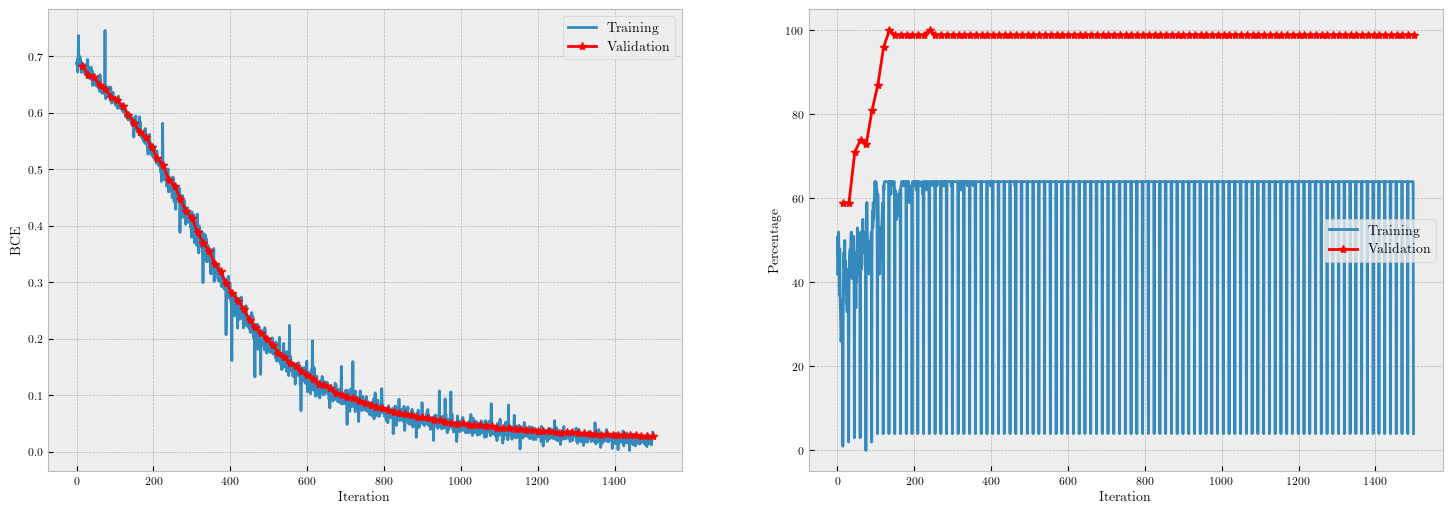

In [234]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

valid_x = np.linspace(len(train_heur['loss'])//nEpochs, len(train_heur['loss']), nEpochs)

axs[0].plot(train_heur['loss'], label='Training')
axs[0].plot(valid_x, valid_heur['loss'], '-*r', label='Validation')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('BCE')
axs[0].legend()

axs[1].plot(train_heur['accuracy'], label="Training")
axs[1].plot(valid_x, valid_heur['accuracy'], '-*r',label='Validation')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Percentage %')
axs[1].legend()

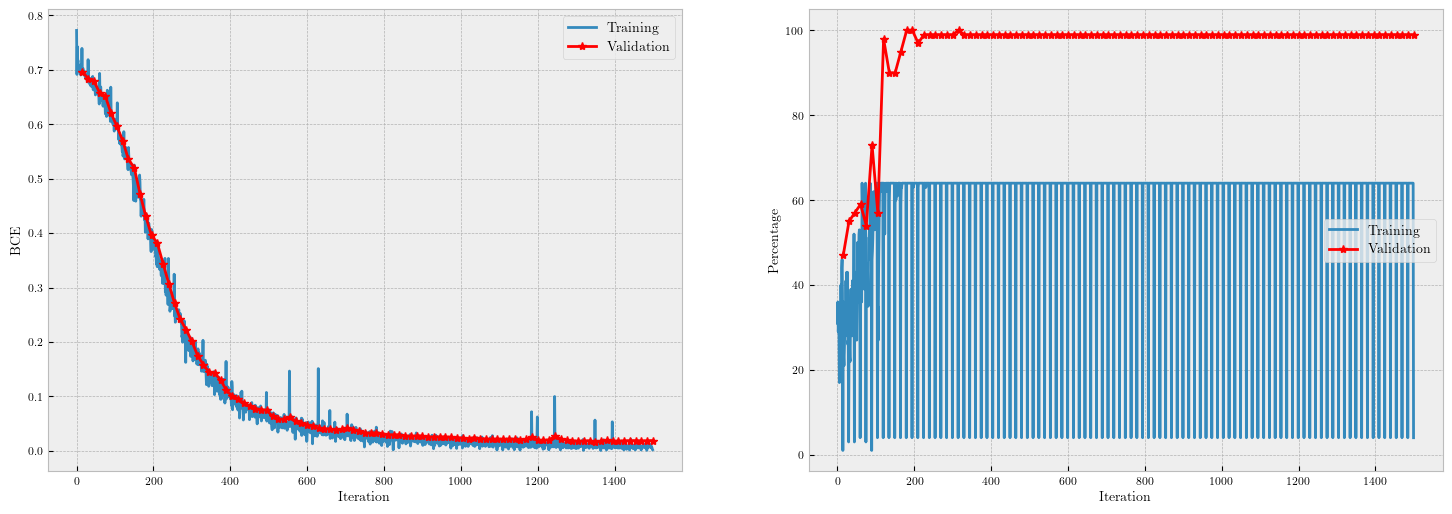

In [244]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

valid_x = np.linspace(len(train_heur['loss'])//nEpochs, len(train_heur['loss']), nEpochs)

axs[0].plot(train_heur['loss'], label='Training')
axs[0].plot(valid_x, valid_heur['loss'], '-*r', label='Validation')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('BCE')
axs[0].legend()

axs[1].plot(train_heur['accuracy'], label="Training")
axs[1].plot(valid_x, valid_heur['accuracy'], '-*r',label='Validation')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Percentage %')
axs[1].legend()

In [204]:
model

XOR_classifier(
  (fc1): Linear(in_features=2, out_features=3, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=3, out_features=2, bias=True)
  (act2): Softmax(dim=1)
)

In [63]:
for p in model.parameters():
    print(help(p))
    break

Help on Parameter in module torch.nn.parameter object:

class Parameter(torch.Tensor)
 |  Parameter(data=None, requires_grad=True)
 |  
 |  A kind of Tensor that is to be considered a module parameter.
 |  
 |  Parameters are :class:`~torch.Tensor` subclasses, that have a
 |  very special property when used with :class:`Module` s - when they're
 |  assigned as Module attributes they are automatically added to the list of
 |  its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
 |  Assigning a Tensor doesn't have such effect. This is because one might
 |  want to cache some temporary state, like last hidden state of the RNN, in
 |  the model. If there was no such class as :class:`Parameter`, these
 |  temporaries would get registered too.
 |  
 |  Args:
 |      data (Tensor): parameter tensor.
 |      requires_grad (bool, optional): if the parameter requires gradient. See
 |          :ref:`locally-disable-grad-doc` for more details. Default: `True`
 |  
 |  Metho

In [143]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters

In [133]:
with torch.no_grad():
    for i in model.parameters():
        print(i)
    y1 = model(X)
    for param in model.parameters():
        param.add_(torch.ones(param.size()) * -10000)
    for i in model.parameters():
        print(i)
    y2 = model(X)

Parameter containing:
tensor([[910.5883, 909.9974],
        [909.7752, 910.5541]], requires_grad=True)
Parameter containing:
tensor([909.6922, 909.7192], requires_grad=True)
Parameter containing:
tensor([[910.4589, 910.6646],
        [910.0820, 910.4756]], requires_grad=True)
Parameter containing:
tensor([910.1758, 910.0831], requires_grad=True)
Parameter containing:
tensor([[-9089.4121, -9090.0029],
        [-9090.2246, -9089.4463]], requires_grad=True)
Parameter containing:
tensor([-9090.3076, -9090.2812], requires_grad=True)
Parameter containing:
tensor([[-9089.5410, -9089.3350],
        [-9089.9180, -9089.5244]], requires_grad=True)
Parameter containing:
tensor([-9089.8242, -9089.9170], requires_grad=True)


In [139]:
with torch.no_grad():
    for i in model.parameters():
        print(dir(i))
        break

['H', 'T', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__idiv__', '__ifloordiv__', '__ilshift__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__long__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__rfloordiv__', '__rlshift__', '__rmatmul__', '__rmod__', '__rmul_

In [245]:
%%time
v = parameters_to_vector(model.parameters())

CPU times: user 355 µs, sys: 47 µs, total: 402 µs
Wall time: 403 µs


In [246]:
%%time
vector_to_parameters(v, model.parameters())

CPU times: user 220 µs, sys: 0 ns, total: 220 µs
Wall time: 192 µs


In [ ]:
def perturb_torch_model(model, loss_fn, dtheta, data_iterator, update_weights=False):
    x, y = next(data_iterator)
    
    cost_prev = loss_fn(model(x), y)
    
    theta = parameters_to_vector(model.parameters())
    vector_to_parameters(thetha + dthetha, model.parameters())
    
    cost = loss_fn(model(x), y)
    if not update_weights:
        vector_to_parameters(thetha, model.parameters())
        
    return cost

In [250]:
iter(train_dataloader)

In [249]:
dir(train_dataloader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_get_shared_seed',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_i